In [1]:
import numpy as np
from PIL import Image
from scipy import ndimage
import pandas as pd
from torchvision import transforms
from torchvision.transforms.functional import crop, pad
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
import shap
import augment_lib
import matplotlib.pyplot as plt

device = "cuda:1" if torch.cuda.is_available() else "cpu"



/home/jielian/anaconda3/envs/dlung/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def pad_bd(cropped_img):
    target_size = [max(np.shape(cropped_img)), max(np.shape(cropped_img))]
    pad_height = max(0, (target_size[0] - np.shape(cropped_img)[0]) // 2)
    pad_width = max(0, (target_size[1] - np.shape(cropped_img)[1]) // 2)
    # Pad the array
    padded_arr = pad(cropped_img, (pad_width, pad_height, pad_width, pad_height))
    return padded_arr

def backgroup_map(image):
    mean_col = np.mean(image)
    # if mean_col < 100:
    image[np.where(image >= [250])] = [0]
    return image

def crop_hf(input_image):
    input_image = np.array(input_image)
    input_image = backgroup_map(input_image)
    input_image = Image.fromarray(input_image)
    witd = np.shape(input_image)[1]
    hights = np.shape(input_image)[0]
    upper = int(hights/6)
    img = crop(input_image, upper,0, witd-1, witd-1)
    # print(np.shape(img))
    # print(np.min(img),np.max(img), np.mean(img))
    return img

train_preprocess = transforms.Compose([
    transforms.Lambda(crop_hf),
    transforms.Lambda(pad_bd),
    transforms.Resize(224),
    augment,
    transforms.ToTensor(), # PyTorch automatically converts all images into [0,1]. 
])

preprocess = transforms.Compose([
    transforms.Lambda(crop_hf),
    transforms.Lambda(pad_bd),
    transforms.Resize(224),
    transforms.ToTensor(), # PyTorch automatically converts all images into [0,1]. 
])

In [3]:
class DenseNetRegression(nn.Module):
    def __init__(self):
        super(DenseNetRegression, self).__init__()
        self.densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        self.densenet.features.conv0 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Adjust other layers if needed
        self.fc = nn.Linear(1024, 1)  # Output layer with 1 neuron for regression task

    def forward(self, x):
        # print(x.size())
        features = self.densenet.features(x)
        # print(features.size())
        out = nn.functional.relu(features, inplace=True)
        # print(out.size())
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

In [4]:
targets ='F'


In [5]:
pth = ''
model = DenseNetRegression()
model.load_state_dict(torch.load(pth))
model = model.to(device)
model.eval()

Using cache found in /home/jielian/.cache/torch/hub/pytorch_vision_v0.10.0
The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.


DenseNetRegression(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

In [6]:
class DXAData(Dataset):
    def __init__(self, df, transform=False):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path1 = self.df['path_11']
        img_path2 = self.df['path_12']
        labels = torch.from_numpy(np.array(self.df['Age when attended assessment centre | Instance 2'])).float()
        label = labels[idx]
        image_filepath1 = img_path1[idx]
        image1 = Image.open(image_filepath1)
        image1 = self.transform(image1)
        image_filepath2 = img_path2[idx]
        image2 = Image.open(image_filepath2)
        image2 = self.transform(image2)
        image =  torch.concat((image1,image2))
        return image, label

In [22]:
hc_train_f = pd.read_csv('data/F_data_train.csv')['Participant ID'].to_list()
hc_val_f = pd.read_csv('data/F_data_val.csv')['Participant ID'].to_list()
hc_test_f = pd.read_csv('data/F_data_test.csv')['Participant ID'].to_list()
hc_list_f = [*hc_train_f, *hc_val_f, *hc_test_f]

hc_train_m = pd.read_csv('data/M_data_train.csv')['Participant ID']
hc_val_m = pd.read_csv('data/M_data_val.csv')['Participant ID']
hc_test_m = pd.read_csv('data/Mdata_test.csv')['Participant ID']
hc_list_m = [*hc_train_m, *hc_val_m, *hc_test_m]

label = pd.read_csv('results/center_all.csv')
label_f = label[label['Sex']== 'Female']
label_m = label[label['Sex']== 'Male']
label_f.reset_index(inplace=True, drop=True)
label_m.reset_index(inplace=True, drop=True)


In [26]:
if targets =='M':
    all_df = label_m
    test_data = pd.read_csv('data/M_data_train.csv')
    hc_list = hc_list_m
else:
    all_df= label_f
    test_data = pd.read_csv('data/F_data_train.csv')
    hc_list = hc_list_f


In [27]:
def BC_label(df, hc_list):
    new_list = []
    for i in range(len(df)):
        l = df.loc[i]
        if l['Participant ID'] in hc_list:
            new_list.append('Normal')
        else:
            ints_cols = l[['T2D Label', 'Hypertension Label', 'MACE Label', 'ASCVD Label']].to_list()
            # print(ints_cols)
            if ints_cols == ['HC', 'HC', 'HC', 'HC']:
                new_list.append('HC')
            else:
                new_list.append('Disease')
    # print(new_list.unique())
    return new_list

In [28]:
def trans(shap_values_t, test_images):
    shap_numpy_t = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2).mean(axis=0) for s in shap_values_t]
    shap_numpy_t = np.expand_dims(shap_numpy_t, axis=-1)
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2).mean(axis=-1)
    test_numpy = np.expand_dims(test_numpy, axis=-1)
    shap_numpy_t = shap_numpy_t.mean(axis=0)
    test_numpy =  -test_numpy.mean(axis=0)
    return shap_numpy_t, test_numpy

In [29]:
all_df['BC_label'] = BC_label(all_df, hc_list)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
test_df = all_df[all_df['Participant ID'].isin(test_data['Participant ID'])]
ascvd_df = all_df[all_df['ASCVD Label'].isin(['Before'])]
non_di_df = all_df[all_df['BC_label'].isin(['HC'])]


test_df_fourties = test_df[test_df.Age_Label == '40-49'].reset_index()
test_df_fifties = test_df[test_df.Age_Label == '50-59'].reset_index()
test_df_sixties = test_df[test_df.Age_Label == '60-69'].reset_index()
test_df_senventies = test_df[test_df.Age_Label == '70-79'].reset_index()

non_di_fourties = non_di_df[non_di_df.Age_Label == '40-49'].reset_index()
non_di_fifties = non_di_df[non_di_df.Age_Label == '50-59'].reset_index()
non_di_sixties = non_di_df[non_di_df.Age_Label == '60-69'].reset_index()
non_di_senventies = non_di_df[non_di_df.Age_Label == '70-79'].reset_index()

ascvd_df_fourties = ascvd_df[ascvd_df.Age_Label == '40-49'].reset_index()
ascvd_df_fifties = ascvd_df[ascvd_df.Age_Label == '50-59'].reset_index()
ascvd_df_sixties = ascvd_df[ascvd_df.Age_Label == '60-69'].reset_index()
ascvd_df_senventies = ascvd_df[ascvd_df.Age_Label == '70-79'].reset_index()

In [34]:
def generate_loader(test_df_fourties,ascvd_df_fourties, non_di_fourties):
    hc_fourties = DXAData(test_df_fourties, preprocess)
    hc_fourties_loader = DataLoader(hc_fourties, batch_size=100, shuffle=False)

    ascvd_fourties = DXAData(ascvd_df_fourties, preprocess)
    ascvd_fourties_loader = DataLoader(ascvd_fourties, batch_size=100, shuffle=False)

    non_di_fourties = DXAData(non_di_fourties, preprocess)
    non_di_fourties_loader = DataLoader(non_di_fourties, batch_size=100, shuffle=False)
    return hc_fourties_loader, ascvd_fourties_loader, non_di_fourties_loader

In [44]:
tage = 60
hc_fourties_loader, ascvd_fourties_loader, non_di_fourties_loader = generate_loader(test_df_sixties,ascvd_df_sixties, non_di_sixties)

In [45]:
#normal reference
hbatch = next(iter(hc_fourties_loader))
himages, _ = hbatch 
# ascvd
dbatch = next(iter(ascvd_fourties_loader))
dimages, _ = dbatch  
# non di
nbatch = next(iter(non_di_fourties_loader))
nimages, _ = nbatch  

background = himages[:20].to(device)
test_images = himages[20:100]
di_images = dimages[0:100]
no_images = nimages[0:100]

e = shap.DeepExplainer(model, background)
shap_values_t = e.shap_values(test_images)
shap_values_d = e.shap_values(di_images)
shap_values_n = e.shap_values(no_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


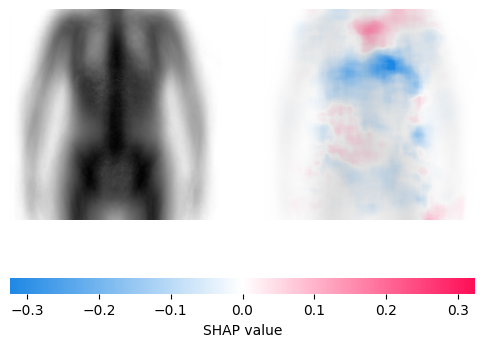

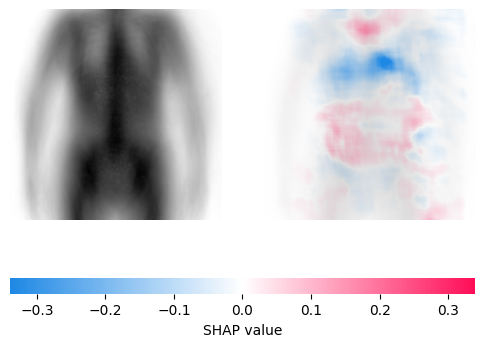

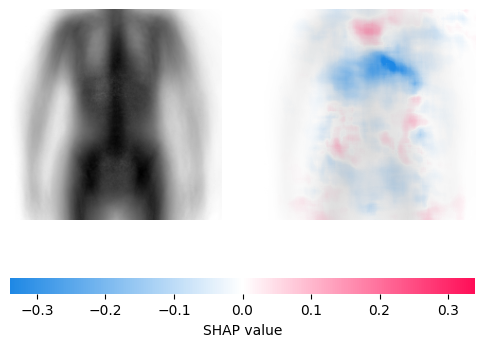

In [48]:
# normal reference
shap_numpy_t, test_numpy = trans(shap_values_t, test_images)
shap_t = ndimage.median_filter(shap_numpy_t,15)
# ascvd reference
shap_numpy_d, di_numpy = trans(shap_values_d, di_images)
shap_d = ndimage.median_filter(shap_numpy_d,15)
# other normal
shap_numpy_n, n_numpy = trans(shap_values_n, no_images)
shap_n = ndimage.median_filter(shap_numpy_n,15)
# plot hc
shap.image_plot(shap_t,test_numpy, show=False)
# plt.savefig('results/analysis/shap/'+targets+'_hc_'+str(tage)+'.png')
shap.image_plot(shap_d,di_numpy, show=False)
# plt.savefig('results/analysis/shap/'+targets+'_ascvd_'+str(tage)+'.png')
shap.image_plot(shap_n,n_numpy, show=False)
# plt.savefig('results/analysis/shap/'+targets+'_normal_'+str(tage)+'.png')
